# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Background:
Given the problem statement, there isn't much background on the customer.  We know that the business is a used car dealership.  The dealership is active and is funding this investigation.

Business Objectives:
The dealership would like us to produce a list of key features that drive vehicle pricing.  We will need to analyze the data and produce a list of key features that correlate to higher pricing.  A model will be produced to predict a sale price of a prospective used car given the features in the training data set.

Business Success Criteria:
- Provide a ranked feature list of features that drive higher pricing
- Provide a model that can be used to predict prospective used car pricing

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Data Set Investigation:
The steps I would follow to get an understanding of the data set are below.  These steps will inform both the Business understanding and the Data Preparation phases of the process.
- List out features
- Evaluate missing data develop a plan on how to handle missing data
- Evaluate non-numeric features and plan on how to handle them in the Data Preparation phase

In [367]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [350]:
cars = pd.read_csv('data/vehicles.csv')

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [351]:
#cars['manufacturer'].value_counts()
#cars['model'].value_counts()
#cars['condition'].value_counts()
#cars['cylinders'].value_counts()
#cars['fuel'].value_counts()
#cars['title_status'].value_counts()
#cars['transmission'].value_counts()
#cars['drive'].value_counts()
#cars['size'].value_counts()
#cars['type'].value_counts()
cars['paint_color'].value_counts()

paint_color
white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: count, dtype: int64

Text(0, 0.5, 'Price')

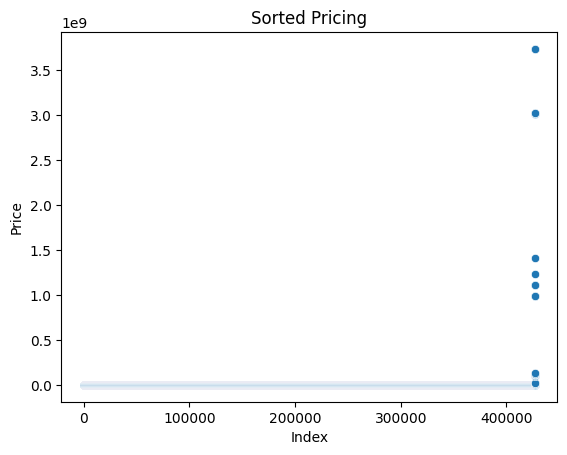

In [352]:
# Let's visualize some of the features
price_sort = cars['price']
plot = sns.scatterplot(x=range(len(price_sort)), y=price_sort.sort_values(ascending=True))
plot.set_title('Sorted Pricing')
plot.set_xlabel("Index")
plot.set_ylabel("Price")

# There looks to be quite a few outliers here.  We'll need to remove them


After investigating the data, the initial plan for the data is listed below.  Some features have very little data and will be removed.
- region - This will be removed.  The region shouldn't be part of the model since the dealership is located in a single region.
- manufacturer, model - Keep
- condition - This has quite a bit of data missing.  I have a feeling this feature will drive pricing.  We'll have to fill in the missing data.
- cylinders - Keep - enumerate
- fuel - Keep - enumerate
- title_status - Keep - enumerate
- transmission - Keep - enumerate
- VIN - remove
- drive - Keep - enumerate
- size - Keep - enumerate
- type - Keep - enumerate
- paint_color - Keep - enumerate
- state - remove - The location doesn't really apply to the car's condition.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

First let's take care of our non-numeric columns so we can produce a correlation matrix to get a sense of what correlates with pricing the most.

In [353]:
# Remove the unwanted columns
cars = cars.drop('region', axis=1)
cars = cars.drop('state', axis=1)
cars = cars.drop('VIN', axis=1)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 48.9+ MB


In [354]:
# We have determined the key parameters at this point so display the unique values here for reference
# We will be enumerating them in the next steps
print(cars['drive'].unique())
print(cars['manufacturer'].unique())

[nan 'rwd' '4wd' 'fwd']
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']


In [355]:
# Enumerate any non-numeric data.  For now, we are going to enumerate from 1 to n
# where n is the total number of unique values in the column

non_numeric_columns = cars.select_dtypes(exclude=['number'])
for c in non_numeric_columns:
    e = 1
    # get the unique values
    for v in non_numeric_columns[c].unique():
        cars[c] = cars[c].replace(v, e)
        e += 1

C:\Users\neilh\AppData\Local\Temp\ipykernel_11172\1073616188.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cars[c] = cars[c].replace(v, e)


In [356]:
# Now let's add some columns.  Instead of the year, let's add age as a column
import datetime
cars['age'] = datetime.datetime.now().year - cars['year']

# Let's try adding a log price column
cars['log10price'] = np.log10(cars['price'])
cars['log2price'] = np.log2(cars['price'])

C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\neilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [357]:
# Now let's investigate the condition column.  It was missing quite a bit of data.  Maybe it needs to be removed.
cars = cars.drop('condition', axis=1)

In [358]:
# Now let's drop all NA's
cars = cars.dropna()
cars = cars.drop('id', axis=1)

75983.55747560189
12262049.979048267
421344
17928.752355227436
11921.318685841563
363553


Text(0, 0.5, 'Price')

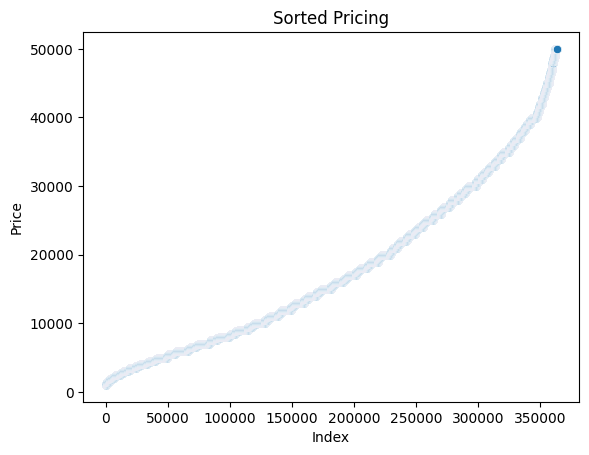

In [359]:
# Lets also check for some outliers and remove them
print(cars['price'].mean())
print(cars['price'].std())
print(len(cars))
cars_no_outliers = cars[(cars['price'] < 50000) & (cars['price'] > 1000)]
print(cars_no_outliers['price'].mean())
print(cars_no_outliers['price'].std())
print(len(cars_no_outliers))

# Try removing some additional columns
cars_no_outliers = cars_no_outliers.drop(['model', 'type'], axis=1)

# Let's visualize the price again
price_sort = cars_no_outliers['price']
plot = sns.scatterplot(x=range(len(price_sort)), y=price_sort.sort_values(ascending=True))
plot.set_title('Sorted Pricing')
plot.set_xlabel("Index")
plot.set_ylabel("Price")


In [360]:
# Let's take a look at the correlation matrix and get a sense of what drives pricing
cars_no_outliers.corr()

,price,year,manufacturer,cylinders,fuel,odometer,title_status,transmission,drive,size,paint_color,age,log10price,log2price
price,1.000000,0.397228,-0.068488,-0.213646,0.206840,-0.207303,-0.079227,-0.340039,-0.118360,-0.225060,-0.056393,-0.397228,0.927974,0.927974
year,0.397228,1.000000,0.090205,-0.038442,0.048029,-0.171704,-0.068793,-0.350591,0.097127,-0.121285,-0.046763,-1.000000,0.429918,0.429918
manufacturer,-0.068488,0.090205,1.000000,0.036568,-0.046970,-0.056280,-0.013320,-0.057900,-0.019992,0.044392,0.028540,-0.090205,-0.050497,-0.050497
cylinders,-0.213646,-0.038442,0.036568,1.000000,-0.122130,0.028128,0.036805,0.190556,0.348737,0.367337,0.227080,0.038442,-0.206965,-0.206965
fuel,0.206840,0.048029,-0.046970,-0.122130,1.000000,0.017327,-0.004464,-0.097165,-0.036551,-0.061492,-0.058018,-0.048029,0.187073,0.187073
odometer,-0.207303,-0.171704,-0.056280,0.028128,0.017327,1.000000,0.021023,0.145195,-0.007687,0.045908,-0.002449,0.171704,-0.222018,-0.222018
title_status,-0.079227,-0.068793,-0.013320,0.036805,-0.004464,0.021023,1.000000,0.061123,0.024457,0.072505,0.039796,0.068793,-0.093113,-0.093113
transmission,-0.340039,-0.350591,-0.057900,0.190556,-0.097165,0.145195,0.061123,1.000000,0.060765,0.227080,0.021070,0.350591,-0.333351,-0.333351
drive,-0.118360,0.097127,-0.019992,0.348737,-0.036551,-0.007687,0.024457,0.060765,1.000000,0.236454,0.237798,-0.097127,-0.089301,-0.089301
size,-0.225060,-0.121285,0.044392,0.367337,-0.061492,0.045908,0.072505,0.227080,0.236454,1.000000,0.247002,0.121285,-0.225021,-0.225021


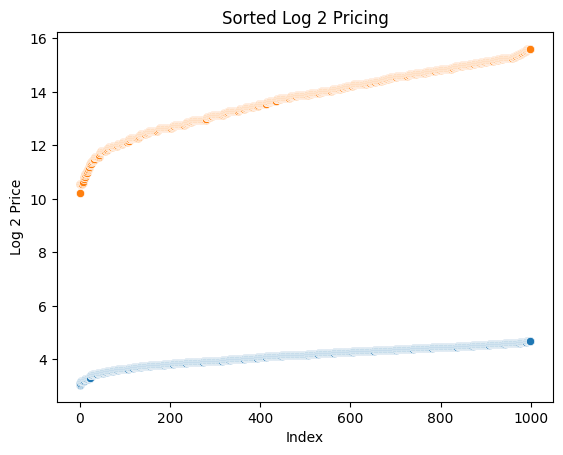

In [361]:
# Let's visualize the price again
price_sort = cars_no_outliers['log10price'].sample(1000).sort_values()
plot10 = sns.scatterplot(x=range(len(price_sort)), y=price_sort)
plot10.set_title('Sorted Log 10 Pricing')
plot10.set_xlabel("Index")
plot10.set_ylabel("Log 10 Price")

price_sort = cars_no_outliers['log2price'].sample(1000).sort_values()
plot2 = sns.scatterplot(x=range(len(price_sort)), y=price_sort)
plot2.set_title('Sorted Log 2 Pricing')
plot2.set_xlabel("Index")
plot2.set_ylabel("Log 2 Price")


y_data = cars_no_outliers['price']
y_log10_data = cars_no_outliers['log10price']
y_log2_data = cars_no_outliers['log2price']
X_data = cars_no_outliers.drop(['price', 'log10price', 'log2price'], axis=1)

# Now we have some other pricing columns to try with our models
X_train, X_test, y_train, y_test = train_test_split(X_data, y_log10_data, test_size=0.33)


In [362]:
# Let's get the data feature reduced.  First we need to determine how many features to include
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
print(n_over_95)

# Principle component names
initial_feature_names = X_train.columns
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_over_95)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_over_95)]
print(most_important_names)

# Reduce the dataset to these columns
X_train = X_train[most_important_names]
X_test = X_test[most_important_names]

print(X_train)

2
['year', 'cylinders']
          year  cylinders
3607    2013.0          1
187582  2014.0          1
51562   2001.0          3
53092   2011.0          1
195745  2015.0          3
...        ...        ...
221286  2020.0          1
355913  1992.0          2
374976  2009.0          1
399355  2002.0          3
91413   2014.0          8

[243580 rows x 2 columns]


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [363]:
# Let's cook up some models and check to see which performs the best
# We need to pipeline a few things together to check

pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', Lasso())
])

# Setup the parameter grid
param_grid = {
    'poly__degree':range(1,6)
}

grid_search_lasso = GridSearchCV(pipe, param_grid=param_grid)

grid_search_lasso.fit(X_train, y_train)

print("Best Params: " + str(grid_search_lasso.best_params_))


Best Params: {'poly__degree': 1}


In [364]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', Ridge())
])

# Setup the parameter grid
param_grid = {
    'poly__degree':range(1,6)
}

grid_search = GridSearchCV(pipe, param_grid=param_grid)

grid_search.fit(X_train, y_train)

print("Best Params: " + str(grid_search.best_params_))


Best Params: {'poly__degree': 5}


In [365]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

# Setup the parameter grid
param_grid = {
    'poly__degree':range(1,6)
}

grid_search = GridSearchCV(pipe, param_grid=param_grid)

grid_search.fit(X_train, y_train)

print("Best Params: " + str(grid_search.best_params_))


Best Params: {'poly__degree': 5}


In [368]:
# Now that we've looked at the best parameters for each regression model
# Let's compare their MSE
lassopipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', Lasso())
])

lassopipe.fit(X_train, y_train)

train_pred = lassopipe.predict(X_train)
test_pred = lassopipe.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print("Lasso train MSE: " + str(train_mse))
print("Lasso test MSE: " + str(test_mse))

ridgepipe = Pipeline([
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', Ridge())
])

ridgepipe.fit(X_train, y_train)

train_pred = ridgepipe.predict(X_train)
test_pred = ridgepipe.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print("Ridge train MSE: " + str(train_mse))
print("Ridge test MSE: " + str(test_mse))

linregpipe = Pipeline([
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

linregpipe.fit(X_train, y_train)

train_pred = linregpipe.predict(X_train)
test_pred = linregpipe.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print("LinearRegression train MSE: " + str(train_mse))
print("LinearRegression test MSE: " + str(test_mse))

Lasso train MSE: 0.12174634982967411
Lasso test MSE: 0.12173528517801618
Ridge train MSE: 0.06017407975164669
Ridge test MSE: 0.060027308849258894
LinearRegression train MSE: 0.053242107313605146
LinearRegression test MSE: 0.05314612315424314


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

I've tried a ton of different combinations of models and parameters and am having trouble getting lower mean squared error.  I needed to go back and remove some other columns out of the dataset and retry.

I was able to get a better model by removing some categorical data.  It still isn't that great.  The data will need to be tweaked a bit more before anything of real value can be provided.  The best indicators I could find for price were 'age', 'drive', and 'manufacturer'.

The Data preparation phase will need to be revisited and some additional techniques will need to be applied.  As of now, I cannot provide a model that will be good enough to make business decisions on.

After taking a another look at the data I found that a log of the price was what a needed to help linearize the data.  After this transformation, I was able to compare the Lasso, Ridge, and LinearRegression models using the GridSearchCV's best parameters.  Please take a look at the README file provided with this notebook for the findings in detail.

In [371]:
# Cross validate the models to determine efficacy
kf = KFold(n_splits=5, shuffle=True)

scores = cross_val_score(lassopipe, X_test, y_test, cv=kf)
print("Lasso scores: " + str(scores))

scores = cross_val_score(ridgepipe, X_test, y_test, cv=kf)
print("Ridge scores: " + str(scores))

scores = cross_val_score(linregpipe, X_test, y_test, cv=kf)
print("LinearRegression scores: " + str(scores))

Lasso scores: [-1.12465160e-04 -1.22333772e-05 -1.02618170e-04 -6.47786232e-05
 -1.60308764e-05]
Ridge scores: [0.50482365 0.50746372 0.50101866 0.5100241  0.5042828 ]
LinearRegression scores: [0.56577962 0.56926548 0.52343683 0.56166852 0.56968183]


The cross validation shows that the model isn't quite as accurate as it seemed with the lower MSE.  More work needs to be done.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

See the provided README file for the report.